In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path(".").resolve().parent.parent))
from RossmannSalesPrediction.helpers.dataprep import timeseries_ttsplit, fix_df, prep_for_model
from RossmannSalesPrediction.helpers import feature_engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



root_path = "../"

#%%
train = pd.read_csv(root_path + 'data/train.csv')
train = fix_df(train)

# ONLY SUBSAMPLE
# train = train.sample(int(0.5 * len(train)), random_state=42)

# ADD ELAPSED
promo_elapsed = (
    train.groupby('date').mean().reset_index()
    .pipe(feature_engineering.time_elapsed, 'promo', 'forward')
    .pipe(feature_engineering.time_elapsed, 'promo', 'backward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'forward')
    .pipe(feature_engineering.time_elapsed, 'schoolholiday', 'backward')
    [['date', 'elapsed_promo_fwd', 'elapsed_promo_backwd', 'elapsed_schoolholiday_fwd', 'elapsed_schoolholiday_backwd']]
)

train = pd.merge(train, promo_elapsed, on=["date"], how='left')


xtrain_raw, xval_raw, ytrain_raw, yval_raw = timeseries_ttsplit(train)

#from sklearn.model_selection import train_test_split
#
#_trainset, _valset = train_test_split(train)
#xtrain_raw = _trainset.drop('sales', axis=1)
#xval_raw = _valset.drop('sales', axis=1)
#ytrain_raw = _trainset.sales
#yval_raw = _valset.sales



xtrain, ytrain = (
    xtrain_raw
    .pipe(feature_engineering.split_date)
    .pipe(feature_engineering.add_avg_customers_per_store, train_data=xtrain_raw)
    .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xtrain_raw, ytrain=ytrain_raw)
    .pipe(feature_engineering.join_store_details)
    .pipe(prep_for_model, y=ytrain_raw)  # must be last, returns x,y tuple
)

#%%
xval, yval = (
    xval_raw
    .pipe(feature_engineering.split_date)
    .pipe(feature_engineering.add_avg_customers_per_store, train_data=xtrain_raw)
    .pipe(feature_engineering.add_avg_sales_per_store, xtrain=xtrain_raw, ytrain=ytrain_raw)
    .pipe(feature_engineering.join_store_details)
    .pipe(prep_for_model, y=yval_raw)  # must be last, returns x,y tuple
)

#lower_bound = np.quantile(ytrain, 0.01)
#upper_bound = np.quantile(ytrain, 0.99)
#
#train_mask = (ytrain > lower_bound) & (ytrain < upper_bound)
#xtrain = xtrain.loc[train_mask, :]
#ytrain = ytrain[train_mask]
#
#xval = xval.loc[(yval > lower_bound) & (yval < upper_bound), :]
#yval = yval[(yval > lower_bound) & (yval < upper_bound)]

assert (xtrain.index == ytrain.index).all()


#%%
embedding_fts = "store dayofweek dayofyear stateholiday monthofyear dayofmonth storetype assortment promointerval weekofyear elapsed_promo_fwd elapsed_promo_backwd elapsed_schoolholiday_fwd elapsed_schoolholiday_backwd".split()

to_be_encoded = embedding_fts#"stateholiday storetype assortment promointerval weekofyear".split()
to_be_scaled = "avg_store_customers avg_store_sales competitiondistance ".split()
leaveasis = "promo schoolholiday promo2".split()
#leaveasis = [x for x in leaveasis if x not in embedding_fts]

#%%
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

oe = OrdinalEncoder()
ss = StandardScaler()

ct = ColumnTransformer([
    ('leavasis', 'passthrough', leaveasis),
    ("ordinalencode", oe, to_be_encoded),
    ("standardscale", ss, to_be_scaled),
])

ct.fit(xtrain)

#%%
xtrain_nn = pd.DataFrame(ct.transform(xtrain), columns=leaveasis + to_be_encoded + to_be_scaled)
xval_nn = pd.DataFrame(ct.transform(xval), columns=leaveasis + to_be_encoded + to_be_scaled)

#%%
# Train numeric/embedding split
xtrain_nn_num = xtrain_nn.loc[:, ~xtrain_nn.columns.isin(embedding_fts)].values
xtrain_nn_emb = xtrain_nn.loc[:, embedding_fts].values

# Validation numeric/embedding split
xval_nn_num = xval_nn.loc[:, ~xval_nn.columns.isin(embedding_fts)].values
xval_nn_emb = xval_nn.loc[:, embedding_fts].values

train_in = np.split(xtrain_nn_emb, xtrain_nn_emb.shape[-1], axis=1) + [xtrain_nn_num]
val_in = np.split(xval_nn_emb, xval_nn_emb.shape[-1], axis=1) + [xval_nn_num]

In [7]:
from tensorflow.keras import backend as K
def rmspe_loss(y_true, y_pred):
    sum = K.sqrt(K.mean(K.square( (y_true - y_pred) /
          K.clip(K.abs(y_true), K.epsilon(), None) + 1e-6 ), axis=-1) )
    return sum*100

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

dimtable = {k: v for k, v in zip(embedding_fts, [xtrain_nn[col].nunique() for col in embedding_fts])}
#%%
num_input = keras.Input(shape=(xtrain_nn_num.shape[1], ))
emb_inputs = [keras.Input(shape=(1, )) for _ in embedding_fts]

emb_table = {
    'store': 10,
    'dayofweek': 6,
    'dayofyear': 6,
    'stateholiday': 2,
    'monthofyear': 6,
    'weekofyear': 10,
    'dayofmonth': 10,
    'storetype': 2,
    'assortment': 2,
    'promointerval': 2,
    'elapsed_promo_fwd': 5,
    'elapsed_promo_backwd': 5,
    'elapsed_schoolholiday_fwd': 5,
    'elapsed_schoolholiday_backwd': 5,
}



emb_layers = [keras.layers.Embedding(input_dim=dimtable[col]+1, output_dim=emb_table[col])(emb_inputs[idx]) for idx, col in enumerate(embedding_fts)]


# num_dense = keras.layers.Dense(units=2**4, activation='relu', kernel_regularizer=keras.regularizers.l2())(num_input)


flats = [keras.layers.Flatten()(x) for x in emb_layers + [num_input]]
concat = keras.layers.Concatenate()(flats)
# concat = keras.layers.BatchNormalization()(concat)
concat = keras.layers.Dropout(0.2)(concat)

hidden_dense = keras.layers.Dense(units=2**9, activation = 'relu', kernel_regularizer=keras.regularizers.l2())(concat)
# hidden_dense = keras.layers.BatchNormalization()(hidden_dense)
hidden_dense = keras.layers.Dropout(0.2)(hidden_dense)
# hidden_dense = keras.layers.Dense(units=64, activation = 'relu', kernel_regularizer=keras.regularizers.l2())(hidden_dense)

hidden_dense = keras.layers.Dense(units=2**13, activation = 'relu', kernel_regularizer=keras.regularizers.l2())(hidden_dense)
# hidden_dense = keras.layers.BatchNormalization()(hidden_dense)
hidden_dense = keras.layers.Dropout(0.2)(hidden_dense)



out = keras.layers.Dense(units=1, activation='linear', )(hidden_dense) # bias_initializer=keras.initializers.Constant(ytrain.mean())

model: keras.Model = keras.Model(inputs=emb_inputs + [num_input], outputs=out)

In [12]:
import tensorflow as tf

model.load_weights(root_path + "models/modelcheckpoint")

In [14]:
preds = model.predict(val_in)

In [21]:
evaldf = pd.DataFrame({
    'real': yval.values.flatten(),
    'pred': preds.flatten(),
    'abs_pcterr': (preds.flatten() - yval.values.flatten())/yval.values.flatten(),
})

In [22]:
evaldf

,real,pred,abs_pcterr
0,5263,6154.901367,0.169466
1,6064,6597.251465,0.087937
2,8314,9782.134766,0.176586
3,13995,11719.291016,-0.162609
4,4822,6453.775879,0.338402
...,...,...,...
175076,1773,3278.489746,0.849120
175077,6787,8251.978516,0.215851
175078,4382,5480.956543,0.250789
175079,18629,18256.810547,-0.019979


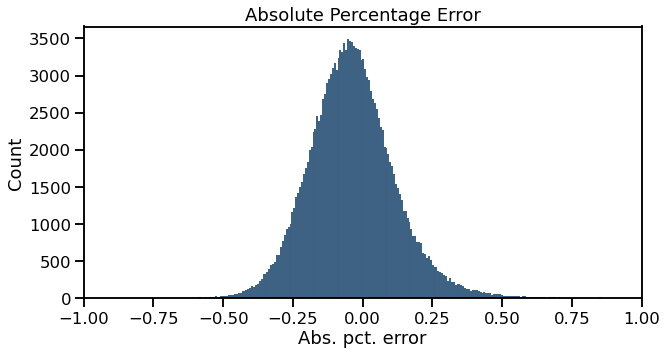

In [37]:
import seaborn as sns

sns.set_context('talk')

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(evaldf.abs_pcterr, color='#00305e')
ax.set(
    xlim=(-1, 1),
    title="Absolute Percentage Error",
    xlabel="Abs. pct. error"
    );


In [46]:
# Best store
best_store = evaldf.abs_pcterr.abs().groupby(xval.store).mean().argmin()
worst_store = evaldf.abs_pcterr.abs().groupby(xval.store).mean().argmax()


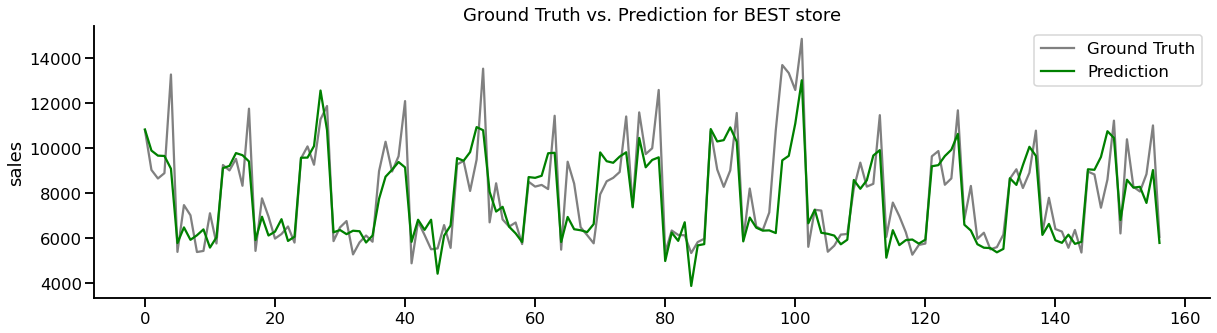

In [75]:
fig, ax = plt.subplots(figsize=(20, 5))
filtered = pd.concat([xval, yval, pd.Series(preds.flatten())], axis=1).rename({0: 'pred'}, axis=1).query("(store == @best_store) & (sales>0)")
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='sales', color='grey', label='Ground Truth')
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='pred', color='green', label='Prediction')
ax.set(
    title="Ground Truth vs. Prediction for BEST store"
)
sns.despine()


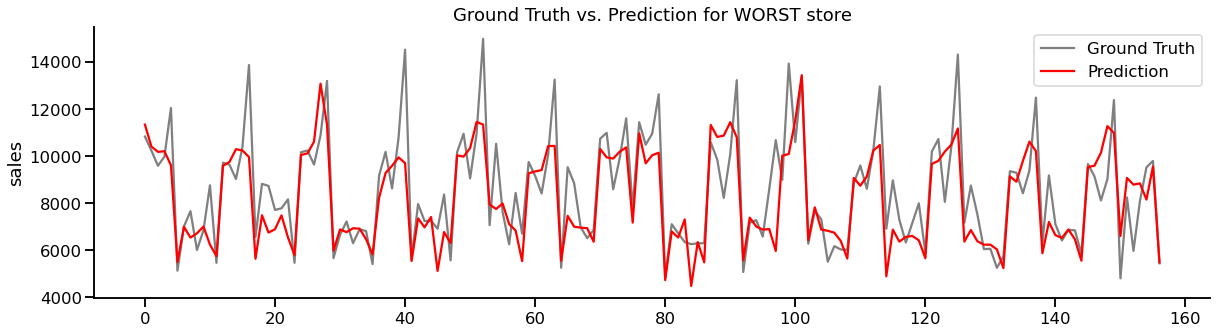

In [76]:
fig, ax = plt.subplots(figsize=(20, 5))
filtered = pd.concat([xval, yval, pd.Series(preds.flatten())], axis=1).rename({0: 'pred'}, axis=1).query("(store == @worst_store) & (sales>0)")
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='sales', color='grey', label='Ground Truth')
sns.lineplot(data=filtered, x=np.arange(len(filtered)), y='pred', color='red', label='Prediction')
ax.set(
    title="Ground Truth vs. Prediction for WORST store"
);
sns.despine()

In [154]:
evaldf = evaldf.assign(
    worst=(evaldf.abs_pcterr > np.quantile(evaldf.abs_pcterr, 0.975)) | (evaldf.abs_pcterr < np.quantile(evaldf.abs_pcterr, 0.025))
)

In [115]:
store_embs = model.layers[14].get_weights()[0][:-1]  # embeddings for store

In [116]:
from sklearn.metrics.pairwise import euclidean_distances

distmat = euclidean_distances(store_embs)

In [117]:
storestates = pd.read_csv('./store_states.csv')

In [118]:
from sklearn.manifold import TSNE

tsne = TSNE()
store_embs_2d = tsne.fit_transform(store_embs)

[Text(0.5, 1.0, 'TSNE representation of 10-dimensional store embeddings (Color = mean sales per store)')]

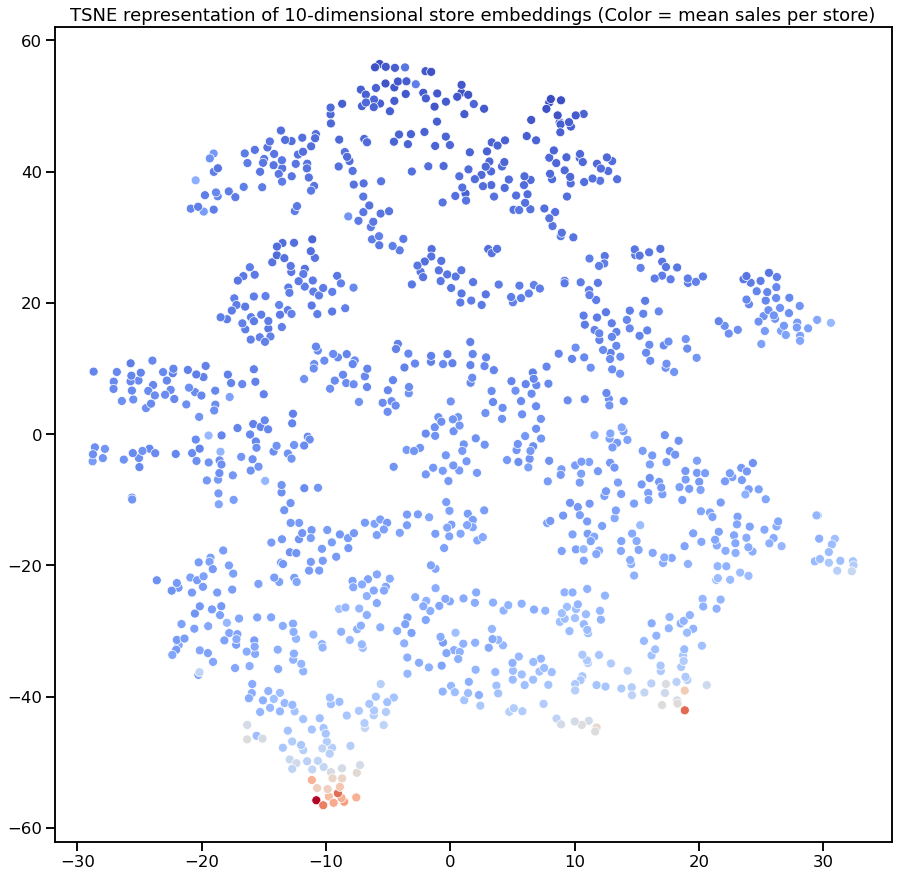

In [151]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(x=store_embs_2d[:, 0], y=store_embs_2d[:, 1], hue=train.groupby('store')['sales'].mean(), palette='coolwarm', legend=False)
ax.set(
    title="TSNE representation of 10-dimensional store embeddings (Color = mean sales per store)"
)